## Postfire Restoration Tool

We are developing this tool using a Jupyter notebook framework. Jupyter has become an extremely important platform for creating reproducible and interactive workflows for scientific computations, and is a good fit for our project since we are in the continual process of refining our model of postfire restoration. The Python backend will allow for integration with a variety of platforms.

Our logic at present is to develop a potential regeneration score that applies across a species community, after computing scores for each species singly.

### Step 0 - Preliminaries

#### Read in species table

The first step is to read in a table of the species-by-species trait characteristics.

In [1]:
import pandas as pd
import numpy as np

In [2]:
import rasterio.plot
import pyproj
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [3]:
traits1 = pd.read_csv("./datasets/SpeciesTableSummary1.csv")
traits1

,Species,PreferredAspect,FunctionalGroup,PreferredTopography,GrowthRateScore,RecruitmentScore,FireCountThreshold,FRITooFrequent,FireSeverityLowMod,FireSeverityHigh,Drought1stYr,Drought2ndYr,NonNatives,ReprodAge
0,Arctostaphylos glauca,variety,seeder,not steep,35,35,1,-80,80,80,50,20,50,10
1,Acmispon glaber,variety,seeder,not steep,80,50,3,-80,80,50,80,20,50,1
2,Ceanothus vestitus,N,seeder,not steep,80,50,1,-80,50,80,80,20,20,5
3,Ceanothus cuneatus,variety,seeder,not steep,75,50,1,-80,50,80,80,20,50,10
4,Ceanothus crassifolius,S,seeder,not steep,20,50,5,-80,50,80,50,20,50,5
5,Adenostoma fasciculatum,S,facultative seeder,not steep,20,50,2,-80,75,35,75,20,80,5
6,Salvia mellifera,variety,facultative seeder,not steep,50,50,2,-50,80,50,50,20,75,2
7,Eriodictyon crassifolium,S,facultative seeder,not steep,75,50,2,-50,75,20,80,20,80,2
8,Eriogonum fasciculatum,S,facultative seeder,not steep,50,35,2,-75,75,50,80,20,35,3
9,Artemisia californica,N,facultative seeder,steep slopes,80,35,1,-80,50,20,75,20,35,3


#### Species inputs

One of our inputs will be lists of species in each ecological unit grouping, with approximate cover rankings. We will use this coding for the cover rankings:

|Cover interval|Cover code|
--------------------|--------------------
|60%-100%|3|
|30%-60%|2|
|0-30%|1|

Coding these breaks into Python:

In [4]:
coverbreaks = [.15, .45, .8]

Here's a sample species list:

In [5]:
specieslist1 = [['Adenostoma fasciculatum', 3], ['Ceanothus cuneatus', 1], ['Salvia mellifera', 1]]


### Determine a potential regeneration score for a single species based on environmental conditions

In [6]:
# Species Step 1 weighting
# take species name, the aspect of the terrain, whether steep or not, and number of fires,
# and output a score for potential regeneration. 
#def speciesstep1(specname, aspect, topography, firecount): # for now don't use topography and aspect
def speciesstep1(specname,firecount, waterbalance='normal'):
    specrow = traits1.loc[traits1['Species']==specname]
    prefaspect = specrow['PreferredAspect'].iloc[0]
    preftopo = specrow['PreferredTopography'].iloc[0]
    maxfire = specrow['FireCountThreshold'].iloc[0]
    functionalgroup = specrow['FunctionalGroup'].iloc[0]
    growthrate = specrow['GrowthRateScore'].iloc[0]
    recruit = specrow['RecruitmentScore'].iloc[0]
    if growthrate > 50:
        adjgrowthrate = 80
    elif growthrate < 50:
        adjgrowthrate = 20
    else:
        adjgrowthrate = 50
    if recruit > 50:
        adjrecruit = 80
    elif recruit < 50:
        adjrecruit = 20
    else:
        adjrecruit = 50
        
        
    # let's start our scoring based on the functional group of the species
    if(functionalgroup == 'sprouter' or functionalgroup == 'facultative seeder'):
        startval = 80
    else: # it's a seeder
        startval = 50
    # if(prefaspect == aspect): For the time being we're ignoring aspect
    #    startval += 20
    # if(preftopo == topography):
    #    startval += 20
    if(waterbalance == 'high'):
        startval += 80
    if(firecount >= maxfire):
        startval -= 40
    # startval += adjgrowthrate # ignoring this for now
    # if(functionalgroup == 'seeder' or functionalgroup == 'facultative seeder'):
     #   startval += adjrecruit
    
    return startval
    

#### A couple of example queries  

Here we are looking at the potential regeneration for a single species under a particular aspect, slope, and number of previous fires. The idea is that this query will be made on a pixel-by-pixel basis.

In [7]:
# What is the potential regeneration for Adenostema fasciculatum on 1 fire in
# the past 40 years and normal water balance?
speciesstep1('Adenostoma fasciculatum', 1, 'normal') 

80

In [8]:
# What is the potential regeneration for Prunus ilicifolia with 3 fires in
# the past 40 years and high water balance?
speciesstep1('Prunus ilicifolia', 3, 'normal')

40

### Determine a potential regeneration score for a single species based on inherent species traits

We combine the attributes of growth rate and recruitment rate here. 

#### This is now folded into the species step 1 function

In [9]:
# Species Step 1 weighting by growth and recruitment rate

def speciessteptraits1(specname):
    specrow = traits1.loc[traits1['Species']==specname]
    growthrate = specrow['GrowthRateScore'].iloc[0]
    recruit = specrow['RecruitmentScore'].iloc[0]
    startval = (growthrate + recruit)/2
    
    return startval

### Combine the scores from each species using a weighted average in the species groups

I am averaging the score from the growth and recruitment rate together with the score from the environmental conditions.

In [10]:
def specgroupstep1(specgroup, aspect, topography, firecount):
    numspecies = len(specgroup)
    speclist = [s[0] for s in specgroup]
    speclistscore = [speciesstep1(spec, aspect, topography, firecount) for spec in speclist]
    speclisttrait = [speciessteptraits1(spec) for spec in speclist]
    coverlevels = [coverbreaks[s[1]-1] for s in specgroup]
    #speclistscore = [speciesstep1(speclist[0], aspect, topography, firecount)]
    covercross = map(lambda x,y,z:y*(x+z)/2,speclistscore,coverlevels, speclisttrait)
    #specgroupscore = sum(covercross)/numspecies 
    specgroupscore = sum(covercross) # maybe we shouldn't divide here
    return specgroupscore

In [11]:
# okay, this is very different now.

def specgroupstep1B(specgroup, firecount, waterbalance):
    numspecies = len(specgroup)
    speclist = [s[0] for s in specgroup]
    speclistscore = [speciesstep1(spec, firecount, waterbalance) for spec in speclist]
    #speclisttrait = [speciessteptraits1(spec) for spec in speclist]
    coverlevels = [coverbreaks[s[1]-1] for s in specgroup]
    #speclistscore = [speciesstep1(speclist[0], aspect, topography, firecount)]
    covercross = map(lambda x,y:y*x,speclistscore,coverlevels)
    #specgroupscore = sum(covercross)/numspecies 
    specgroupscore = sum(covercross) # maybe we shouldn't divide here
    return specgroupscore

#### A couple of example conditions with this species list. (specieslist1)

|Species|Cover percentage|
|-------|------------|
|Adenostema fasciculatum|60-100%|
|Ceanothus cuneatus|0-30%|
|Salvia mellifera|0-30%|

First, with a count of 3 fires and a high water balance:

In [12]:
specgroupstep1B(specieslist1, 3, 'high')

127.5

Next, with 1 fire in past 40 years and normal water balance.

In [13]:
specgroupstep1B(specieslist1, 1, 'normal')

77.5

## Step 1 - Potential regeneration

I will show the rasters we are working with below.

### Count of fires in the 40 years prior to 2002

In [14]:
firecount = rasterio.open("datasets/firecount1962_2001CFmask.tif")

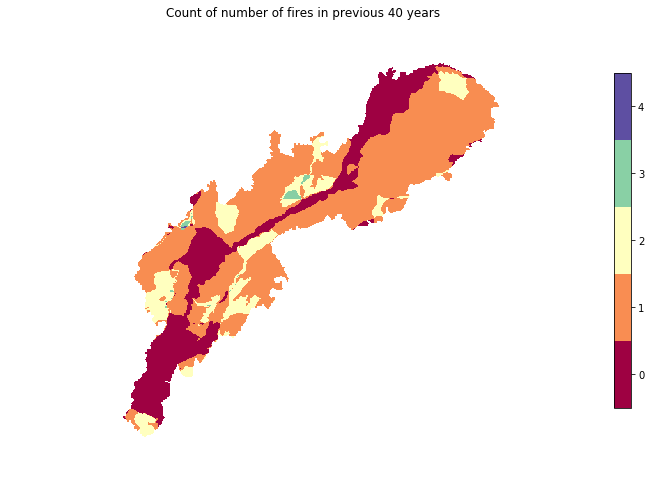

In [15]:
# rasterio.plot.show(firecount,1)
fig, ax = plt.subplots(figsize=(15,8))
cmap = plt.get_cmap('Spectral', 5)
cmap.set_over(alpha=0)
firecountplot = ax.imshow(firecount.read(1,), cmap=cmap, vmin=-0.5, vmax=4.5)
cbar = fig.colorbar(firecountplot, fraction=0.02, ticks=range(5))
# cbar.ax.set_yticklabels(veglabels)
ax.set(title="Count of number of fires in previous 40 years")
ax.set_axis_off();

### Vegetation landscapes

We have combined aspect, physiography, and vegetation groups to create a map of different landscape classes. For the physiography we are using groupings of geomorphons which are a way of describing landscape physiography using a pattern identification algorithm. The categories for these are as below:

- 0:AGS (annual grassland) ; summits and ridges
- 1:AGS; valleys and depressions
- 2:AGS; north-facing slopes/spurs/hollows/footslopes/shoulders
- 3:AGS; south-facings slopes/spurs/hollows/footslopes/shoulders
- 4:CRC (chamise-redshanks chaparral) ; summits and ridges
- 5:CRC; valleys and depressions
- 6:CRC; north-facing slopes/spurs/hollows/footslopes/shoulders
- 7:CRC; south-facings slopes/spurs/hollows/footslopes/shoulders
- 8:MCH (mixed chaparral) ; summits and ridges
- 9:MCH; valleys and depressions
- 10:MCH; north-facing slopes/spurs/hollows/footslopes/shoulders
- 11:MCH; south-facings slopes/spurs/hollows/footslopes/shoulders
- 12:VRI (valley riparian woodland) ; valleys and depressions
- 13:VRI; north-facing slopes/spurs/hollows/footslopes/shoulders
- 14:VRI; south-facings slopes/spurs/hollows/footslopes/shoulders
- 15:CSC (coastal sage scrub) ; summits and ridges
- 16:CSC; valleys and depressions
- 17:CSC; north-facing slopes/spurs/hollows/footslopes/shoulders
- 18:CSC; south-facings slopes/spurs/hollows/footslopes/shoulders
- 19:Other; summits and ridges
- 20:Other; valleys and depressions
- 21:Other; north-facing slopes/spurs/hollows/footslopes/shoulders
- 22:Other; south-facings slopes/spurs/hollows/footslopes/shoulders

In [16]:
# Generate random colormap
# From https://github.com/delestro/rand_cmap
def rand_cmap(nlabels, coltype="bright", first_color_black="False", last_color_black="False", verbose="False"):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys

    if coltype not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if coltype == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
                          np.random.uniform(low=0.9, high=1)) for i in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if coltype == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in range(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap


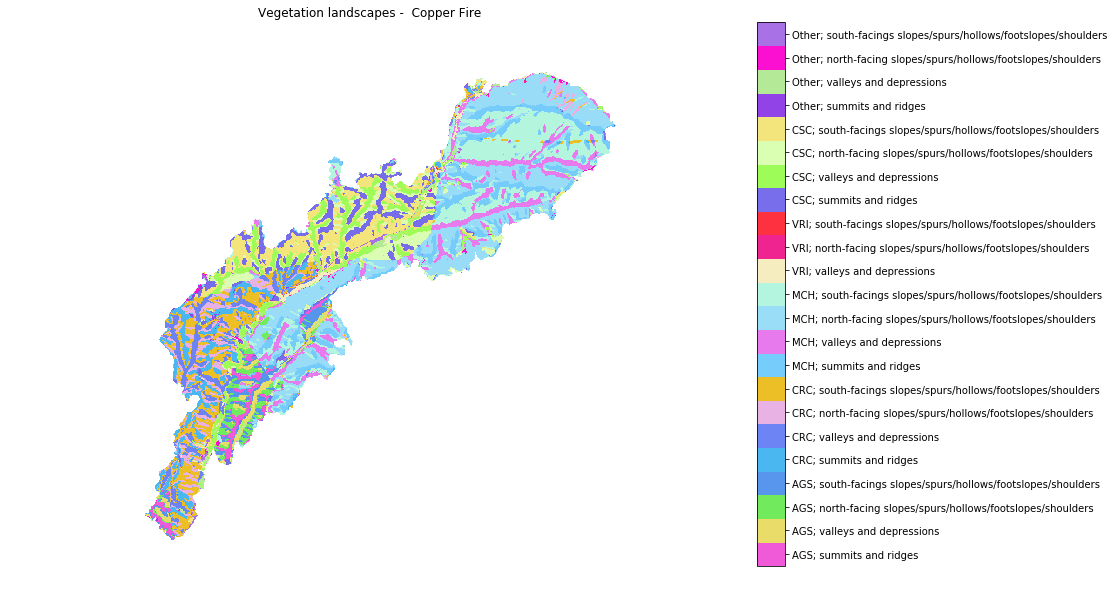

In [17]:
nsgeoxWHR = rasterio.open("datasets/nsgeoxWHR.tif")
random_cmap = rand_cmap(23, coltype='bright', first_color_black=False, last_color_black=False, verbose=False)
#rasterio.plot.show(nsgeoxWHR,1)
fig, ax = plt.subplots(figsize=(18,10))
# cmap = plt.get_cmap('Spectral', 22)
veglabels = ['AGS; summits and ridges', 
             'AGS; valleys and depressions', 
             'AGS; north-facing slopes/spurs/hollows/footslopes/shoulders',
             'AGS; south-facings slopes/spurs/hollows/footslopes/shoulders',
             'CRC; summits and ridges',
             'CRC; valleys and depressions',
             'CRC; north-facing slopes/spurs/hollows/footslopes/shoulders',
             'CRC; south-facings slopes/spurs/hollows/footslopes/shoulders',
             'MCH; summits and ridges',
             'MCH; valleys and depressions',
             'MCH; north-facing slopes/spurs/hollows/footslopes/shoulders',
             'MCH; south-facings slopes/spurs/hollows/footslopes/shoulders',
             'VRI; valleys and depressions',
             'VRI; north-facing slopes/spurs/hollows/footslopes/shoulders',
             'VRI; south-facings slopes/spurs/hollows/footslopes/shoulders',
             'CSC; summits and ridges',
             'CSC; valleys and depressions',
             'CSC; north-facing slopes/spurs/hollows/footslopes/shoulders',
             'CSC; south-facings slopes/spurs/hollows/footslopes/shoulders',
             'Other; summits and ridges',
             'Other; valleys and depressions',
             'Other; north-facing slopes/spurs/hollows/footslopes/shoulders',
             'Other; south-facings slopes/spurs/hollows/footslopes/shoulders']
random_cmap.set_over(alpha=0)
nsgeoxWHRplot = ax.imshow(nsgeoxWHR.read(1,), cmap=random_cmap, vmin=-0.5, vmax=22.5)
cbar = fig.colorbar(nsgeoxWHRplot, fraction=0.04, ticks=range(23))
cbar.ax.set_yticklabels(veglabels)
ax.set(title="Vegetation landscapes -  Copper Fire")
ax.set_axis_off();

### Slope

In [18]:
slope = rasterio.open("datasets/slopeCFmask.tif")


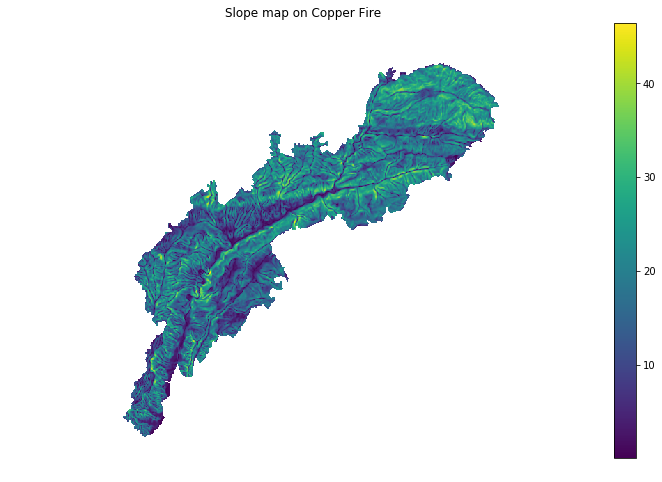

In [19]:
# let's make a big plot
fig, ax = plt.subplots(figsize=(15,8))
slopeplot = ax.imshow(slope.read(1,), cmap='viridis')
fig.colorbar(slopeplot, fraction=.05)
ax.set(title="Slope map on Copper Fire")
ax.set_axis_off();

### Climatic Water Deficit

We'll use this to indicate high water table. For now I'll just use the 30-year mean (1981-2010).

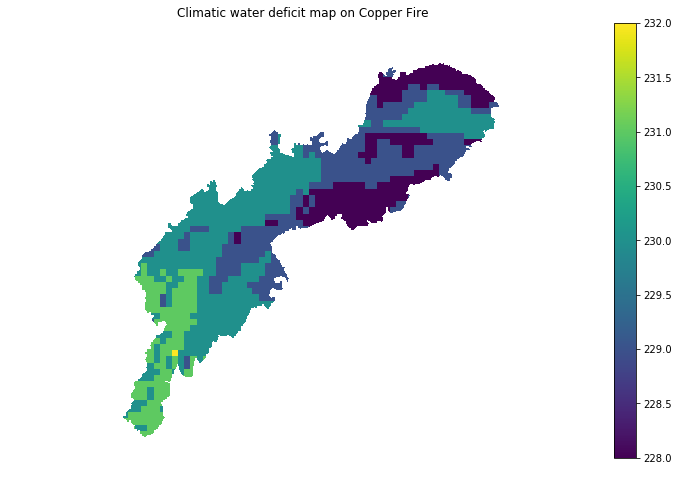

In [20]:
cwd = rasterio.open("datasets/cwd1981_2010Copper.tif")
fig, ax = plt.subplots(figsize=(15,8))
cwdplot = ax.imshow(cwd.read(1,), cmap='viridis', vmin=228,vmax=232)
fig.colorbar(cwdplot, fraction=.05)
ax.set(title="Climatic water deficit map on Copper Fire")
ax.set_axis_off();

There's not a lot of variation here!

### Making up some species lists

These aren't meant to be real. I'm coming up with assignments of species to the vegetation landscape classes.

In [21]:
spececodict = {1: [['Prunus ilicifolia', 2], ['Artemisia californica', 2], ['Eriogonum fasciculatum', 2]],
               2: [['Ceanothus leucodermis', 2], ['Ceanothus cuneatus', 2], ['Eriodictyon crassifolium', 2]],
               3: [['Adenostoma fasciculatum', 3], ['Ceanothus cuneatus', 1], ['Quercus berberidifolia', 1]],
               4: [['Adenostoma fasciculatum', 3], ['Ceanothus leucodermis', 1], ['Acmispon glaber', 1]],
               8: [['Salvia mellifera', 3], ['Hesperoyucca whipplei', 1]],
               9: [['Artemisia californica', 3], ['Malacothamnus fasciculatus', 1], ['Salvia mellifera', 1]],
               10: [['Artemisia californica', 3], ['Ceanothus cuneatus', 1], ['Ceanothus crassifolius', 1]],
               11: [['Eriodictyon crassifolium', 3], ['Ceanothus cuneatus', 1], ['Salvia mellifera', 1]],
               12: [['Arctostaphylos glauca', 2], ['Ceanothus cuneatus', 2], ['Salvia mellifera', 2]]}

In [22]:
spececodict2 = {0: [['Hesperoyucca whipplei', 1]],
               1: [['Hesperoyucca whipplei', 1],['Artemisia californica', 1]],
               2: [['Hesperoyucca whipplei', 1],['Artemisia californica', 1]],
               3: [['Hesperoyucca whipplei', 1],['Artemisia californica', 1]],
               4: [['Adenostoma fasciculatum', 3], ['Ceanothus cuneatus', 1], ['Quercus berberidifolia', 1]],
               5: [['Adenostoma fasciculatum', 3], ['Ceanothus leucodermis', 1], ['Acmispon glaber', 1]],
               6: [['Adenostoma fasciculatum', 3], ['Ceanothus cuneatus', 1], ['Quercus berberidifolia', 1]],
               7: [['Adenostoma fasciculatum', 3], ['Ceanothus crassifolius', 1], ['Arctostaphylos glauca', 1]],
               8: [['Prunus ilicifolia', 2], ['Artemisia californica', 2], ['Eriogonum fasciculatum', 2]],
               9: [['Ceanothus leucodermis', 2], ['Ceanothus cuneatus', 2], ['Eriodictyon crassifolium', 2]], 
               10: [['Eriodictyon crassifolium', 3], ['Ceanothus cuneatus', 1], ['Salvia mellifera', 1]],
               11: [['Arctostaphylos glauca', 2], ['Ceanothus cuneatus', 2], ['Salvia mellifera', 2]],
               12: [['Prunus ilicifolia', 2]],
               13: [['Rhamnus ilicifolia', 2]],
               14: [['Artemisia californica', 1]],
               15: [['Artemisia californica', 3], ['Malacothamnus fasciculatus', 1], ['Salvia mellifera', 1]],
               16: [['Artemisia californica', 3], ['Ceanothus cuneatus', 1], ['Ceanothus crassifolius', 1]],
               17: [['Eriodictyon crassifolium', 1], ['Ceanothus cuneatus', 1], ['Salvia mellifera', 3]],
               18: [['Salvia mellifera', 3], ['Hesperoyucca whipplei', 1]],
               19: [['Prunus ilicifolia', 2], ['Artemisia californica', 2], ['Eriogonum fasciculatum', 2]],
               20: [['Ceanothus leucodermis', 2], ['Ceanothus cuneatus', 2], ['Eriodictyon crassifolium', 2]],
               21: [['Ceanothus vestitus', 3], ['Ceanothus cuneatus', 1], ['Salvia mellifera', 1]],
               22: [['Arctostaphylos glauca', 2], ['Ceanothus cuneatus', 2], ['Salvia mellifera', 2]]}

In [23]:
spececodict2[2]

[['Hesperoyucca whipplei', 1], ['Artemisia californica', 1]]

We now want a function to wrap the values in the rasters (which are integer, integer, and float) and return the species group score. This should be robust to all the values in the rasters, including what it uses as NAs.

This depends on the raster: for firecount and nsgeomorphon, it's 255.0, for slope it's nan.

In [24]:
# DEPRECATED
def rastervalStep1a(specname, nsgeomorphon, firecount, slope):
    #if ((nsgeomorphon == 255 ) or (firecount == 255) or np.isnan(slope)):
    #if ((nsgeomorphon == 255 ) or (firecount == 255) or (slope > 10000)):
    if np.any([nsgeomorphon == 255, firecount == 255, np.isnan(slope)]):    
       return np.nan
    else:
        if(nsgeomorphon == 11):
            nsgeomorphon2 = 'N'
        elif(nsgeomorphon == 12):
            nsgeomorphon2 = 'S'
        else:
            nsgeomorphon2 = 'variety'
        
        if (slope > 25):
            slope2 = 'steep slopes'
        else:
            slope2 = 'not steep'
    # print(nsgeomorphon2, slope2, firecount)
        specval = speciesstep1(specname, nsgeomorphon2, slope2, firecount)
        return specval

    

In [25]:
# DEPRECATED
# calculate the raster map
def rastervalStep1b(specname, nsgeomorphonrast, firecountrast, sloperast):
    nsgeomorphonrast2 = nsgeomorphon.read()
    firecountrast2 = firecountrast.read()
    sloperast2 = sloperast.read()
    vfunc = np.vectorize(rastervalStep1a) # this is key.
    # outrast = rastervalStep1a(specname, nsgeomorphonrast2, firecountrast2, sloperast2)
    outrast = vfunc(specname, nsgeomorphonrast2, firecountrast2, sloperast2)
    return outrast
    

In [26]:
# def rastervalStep1aB(specname, firecount, waterbalance='normal'):
def rastervalStep1aB(specname, firecount, cwd):

    #if ((nsgeomorphon == 255 ) or (firecount == 255) or np.isnan(slope)):
    #if ((nsgeomorphon == 255 ) or (firecount == 255) or (slope > 10000)):
    if np.any([ firecount == 255]):    
        return np.nan
    else:
    # print(nsgeomorphon2, slope2, firecount)
        if cwd <= 229: # obviously tuned to the Copper fire map
            waterbalance = "high"
        else:
            waterbalance = "normal"
        specval = speciesstep1(specname, firecount, waterbalance)
        return specval


In [27]:
# calculate the raster map
def rastervalStep1bB(specname, firecountrast, cwdrast):
#def rastervalStep1bB(specname, firecountrast, waterbalance='normal'):
    firecountrast2 = firecountrast.read()
    cwdrast2 = cwdrast.read()
    vfunc = np.vectorize(rastervalStep1aB) # this is key.
    # outrast = rastervalStep1a(specname, nsgeomorphonrast2, firecountrast2, sloperast2)
    outrast = vfunc(specname, firecountrast2,cwdrast2)
    return outrast

In [28]:
chamiserast = rastervalStep1bB('Adenostoma fasciculatum', firecount, cwd)

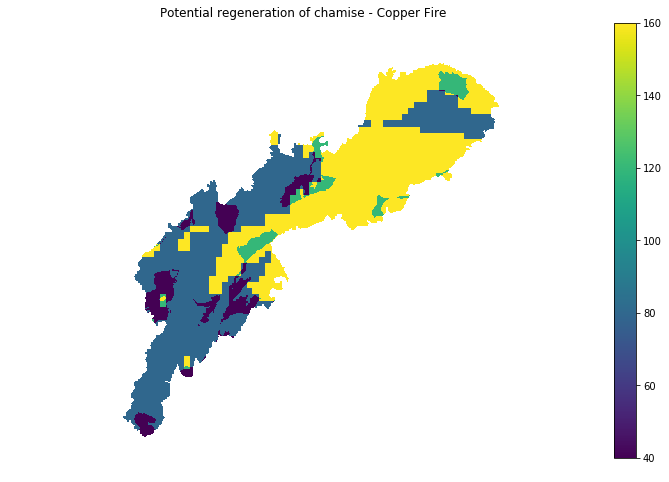

In [29]:
# rasterio.plot.show(chamiserast,1)
fig, ax = plt.subplots(figsize=(15,8))
chamiseplot = ax.imshow(chamiserast[0,], cmap='viridis')
fig.colorbar(chamiseplot, fraction=.05)
ax.set(title="Potential regeneration of chamise - Copper Fire")
ax.set_axis_off();

It looks like we lost our georeferencing here but that can be fixed.

I think the story is that using the rasterio framework, you put the georeferencing back in at output time.

In [30]:
spececodict2[3]

[['Hesperoyucca whipplei', 1], ['Artemisia californica', 1]]

In [31]:
# similar code for the species groups
def rastervalStep1aBgroup(specgroupcode, firecount, cwd):

    #if ((nsgeomorphon == 255 ) or (firecount == 255) or np.isnan(slope)):
    #if ((nsgeomorphon == 255 ) or (firecount == 255) or (slope > 10000)):
    if np.any([ firecount == 255]):    
        return np.nan
    else:
    # print(nsgeomorphon2, slope2, firecount)
        if cwd <= 229: # obviously tuned to the Copper fire map
            waterbalance = "high"
        else:
            waterbalance = "normal"
        specgroup = spececodict2[specgroupcode]
        specval = specgroupstep1B(specgroup, firecount, waterbalance)
        return specval

In [32]:
# calculate the raster map
def rastervalStep1bB(vegrast, firecountrast, cwdrast):
#def rastervalStep1bB(specname, firecountrast, waterbalance='normal'):
    firecountrast2 = firecountrast.read()
    cwdrast2 = cwdrast.read()
    vegrast2 = vegrast.read()
    vfunc = np.vectorize(rastervalStep1aBgroup) # this is key.
    # outrast = rastervalStep1a(specname, nsgeomorphonrast2, firecountrast2, sloperast2)
    outrast = vfunc(vegrast2, firecountrast2,cwdrast2)
    return outrast

In [33]:
vegregenrast = rastervalStep1bB(nsgeoxWHR,firecount, cwd)

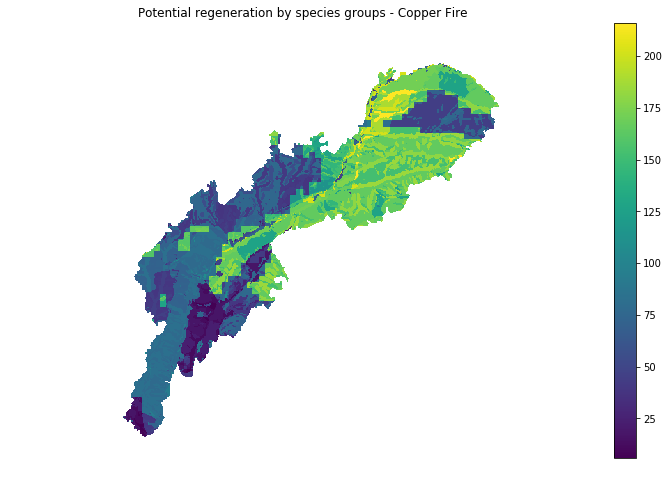

In [34]:
fig, ax = plt.subplots(figsize=(15,8))
vegregenplot = ax.imshow(vegregenrast[0,], cmap='viridis')
fig.colorbar(vegregenplot, fraction=.05)
ax.set(title="Potential regeneration by species groups - Copper Fire")
ax.set_axis_off();

## Step 2 - Impacts of the Fire

### Read in the fire severity and herbaceous cover layers

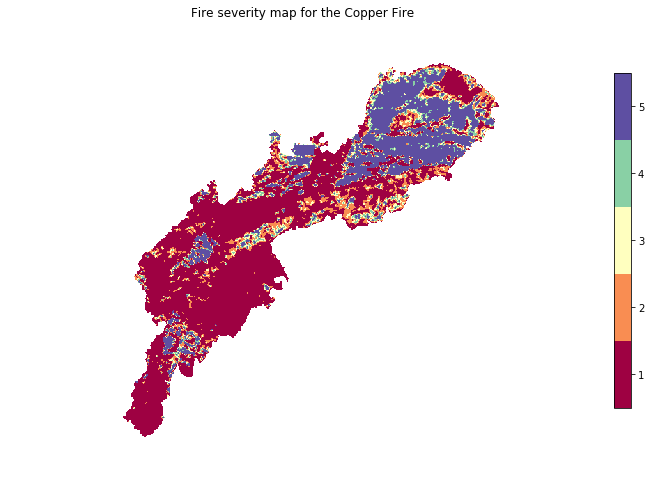

In [35]:
# Fire severity map
firesev = rasterio.open("datasets/vegburnseverityCopper.tif")
fig, ax = plt.subplots(figsize=(15,8))
cmap = plt.get_cmap('Spectral', 5)
cmap.set_over(alpha=0)
firesevplot = ax.imshow(firesev.read(1,), cmap=cmap, vmin=0.5,vmax=5.5)
cbar = fig.colorbar(firesevplot, fraction=0.02, ticks=range(6))
ax.set(title="Fire severity map for the Copper Fire")
ax.set_axis_off();

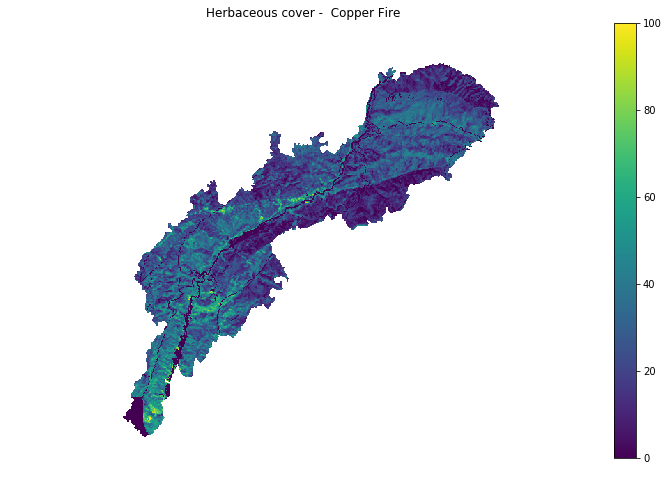

In [36]:
# herbaceous data
herb = rasterio.open("datasets/herbaceous_2011_copper.tif")
fig, ax = plt.subplots(figsize=(15,8))
herbplot = ax.imshow(herb.read(1,), cmap='viridis',vmin=0)
fig.colorbar(herbplot, fraction=.05)
ax.set(title="Herbaceous cover -  Copper Fire")
ax.set_axis_off();